# GhostNet Exploration

In [3]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow.keras as keras
import time

In [5]:
mnist_data = mnist.load_data()
(X_train, Y_train), (X_test, Y_test) = mnist_data

In [6]:
X_train = np.expand_dims(X_train, axis=-1) / 255.0
X_test = np.expand_dims(X_test, axis=-1) / 255.0

In [7]:
# Define the GhostNet building blocks
def ghost_module(x, out_channels, ratio=2, dw_kernel_size=3, s=1):
    init_channels = int(np.ceil(out_channels / ratio))
    new_channels = init_channels * (ratio - 1)
    
    # Primary convolution
    primary_conv = layers.Conv2D(init_channels, kernel_size=1, strides=s, padding='same')(x)
    primary_conv = layers.BatchNormalization()(primary_conv)
    primary_conv = layers.ReLU()(primary_conv)
    
    # Depthwise convolution
    depthwise_conv = layers.DepthwiseConv2D(kernel_size=dw_kernel_size, strides=s, padding='same')(primary_conv)
    depthwise_conv = layers.BatchNormalization()(depthwise_conv)
    depthwise_conv = layers.ReLU()(depthwise_conv)
    
    # Ghost feature maps (pointwise conv to generate extra features)
    ghost_conv = layers.Conv2D(new_channels, kernel_size=1, strides=1, padding='same')(depthwise_conv)
    ghost_conv = layers.BatchNormalization()(ghost_conv)
    ghost_conv = layers.ReLU()(ghost_conv)
    
    # Concatenate primary and ghost
    out = layers.Concatenate()([primary_conv, ghost_conv])
    
    return out

# Building a simple GhostNet-based model for MNIST
def build_ghostnet(input_shape=(28, 28, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    
    # Initial stem layer
    x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # First ghost block
    x = ghost_module(x, out_channels=32)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    # Second ghost block
    x = ghost_module(x, out_channels=64)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    # Third ghost block
    x = ghost_module(x, out_channels=128)
    
    # Global average pooling and dense layer for classification
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)

    return model

In [8]:
# Build the GhostNet model
model = build_ghostnet()
model.summary()    

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 28, 28, 16)   0           ['batch_normalization[0][0]']

In [9]:
from keras.utils import plot_model
!pip install pydot

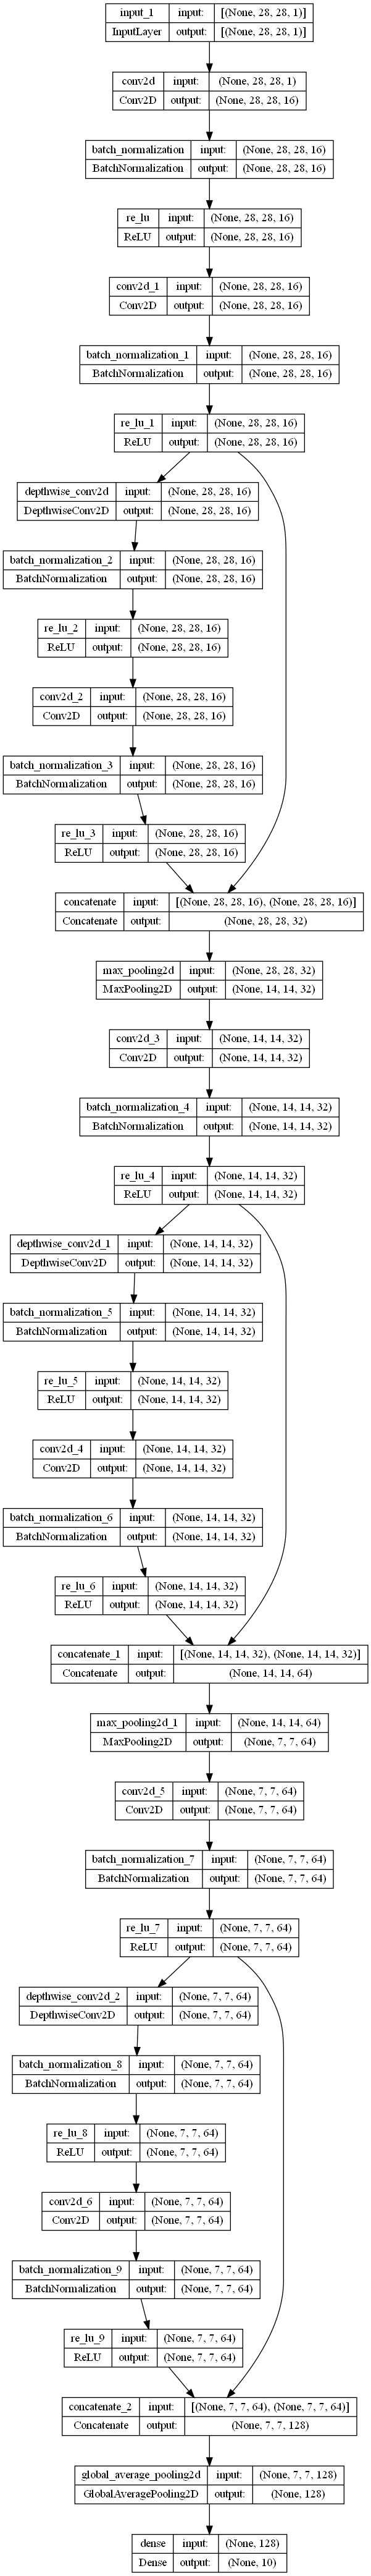

In [10]:
plot_model(model, to_file='model_ghostnet_mnist_architecture.png', show_shapes=True, show_layer_names=True)

In [11]:
import pandas as pd
table_ghost_arch=pd.DataFrame(columns=["Name","Type","Shape"])
for layer in model.layers:
    new_row = {"Name":layer.name, "Type": layer.__class__.__name__,"Shape":layer.output_shape}
    table_ghost_arch = pd.concat([table_ghost_arch, pd.DataFrame([new_row])], ignore_index=True)

In [12]:
table_ghost_arch.head()

,Name,Type,Shape
0,input_1,InputLayer,"[(None, 28, 28, 1)]"
1,conv2d,Conv2D,"(None, 28, 28, 16)"
2,batch_normalization,BatchNormalization,"(None, 28, 28, 16)"
3,re_lu,ReLU,"(None, 28, 28, 16)"
4,conv2d_1,Conv2D,"(None, 28, 28, 16)"


In [13]:
table_ghost_arch

,Name,Type,Shape
0,input_1,InputLayer,"[(None, 28, 28, 1)]"
1,conv2d,Conv2D,"(None, 28, 28, 16)"
2,batch_normalization,BatchNormalization,"(None, 28, 28, 16)"
3,re_lu,ReLU,"(None, 28, 28, 16)"
4,conv2d_1,Conv2D,"(None, 28, 28, 16)"
5,batch_normalization_1,BatchNormalization,"(None, 28, 28, 16)"
6,re_lu_1,ReLU,"(None, 28, 28, 16)"
7,depthwise_conv2d,DepthwiseConv2D,"(None, 28, 28, 16)"
8,batch_normalization_2,BatchNormalization,"(None, 28, 28, 16)"
9,re_lu_2,ReLU,"(None, 28, 28, 16)"


In [15]:
table_ghost_arch.to_csv('ghostnet-architecture.csv', sep=',', index=False, encoding='utf-8')

In [17]:

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on MNIST
start_original_time = time.time()
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10) # Epochs 3 aja udah gacor, tapi secara waktu sama aja wokawo, 3x lipat per-epoch
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

end_time = time.time()
total_time = end_time - start_original_time 
print(f"Total time: {total_time:.2f} seconds")

Epoch 1/10
1875/1875 [==============================] - 76s 39ms/step - loss: 0.3469 - accuracy: 0.9178 - val_loss: 0.1437 - val_accuracy: 0.9573
Epoch 2/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0828 - accuracy: 0.9758 - val_loss: 0.1064 - val_accuracy: 0.9673
Epoch 3/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0582 - accuracy: 0.9825 - val_loss: 0.0778 - val_accuracy: 0.9753
Epoch 4/10
1875/1875 [==============================] - 117s 62ms/step - loss: 0.0489 - accuracy: 0.9857 - val_loss: 0.0622 - val_accuracy: 0.9793
Epoch 5/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0421 - accuracy: 0.9870 - val_loss: 0.0408 - val_accuracy: 0.9864
Epoch 6/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0378 - accuracy: 0.9883 - val_loss: 0.0395 - val_accuracy: 0.9881
Epoch 7/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 0.0532 

In [19]:
# Evaluate original model
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

313/313 [==============================] - 3s 9ms/step - loss: 0.0451 - accuracy: 0.9852
Test accuracy: 0.9851999878883362


In [22]:
import os

original_model = model

# model_save_path = 'cnn_model.h5'
model_save_path = 'model2.keras'
original_model.save(model_save_path)

# Get the size of the model in bytes
model_size = os.path.getsize(model_save_path)
print(f"Model size: {model_size / 1024:.2f} KB")

Model size: 380.66 KB


# Pruning

In [26]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot  # TensorFlow Model Optimization toolkit

In [29]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
      # 'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=100)
  }

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

pruned_model = prune_low_magnitude(original_model, **pruning_params)

# Use smaller learning rate for fine-tuning
opt = keras.optimizers.Adam()

pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

pruned_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 prune_low_magnitude_conv2d_259  (None, 28, 28, 16)  306         ['input_2[0][0]']                
  (PruneLowMagnitude)                                                                             
                                                                                                  
 prune_low_magnitude_batch_norm  (None, 28, 28, 16)  65          ['prune_low_magnitude_conv2d_259[
 alization_259 (PruneLowMagnitu                                  0][0]']                          
 de)                                                                                        

In [30]:
start_pruning_time = time.time()
pruned_model.fit(
  X_train,
  y_train,
  # epochs=10,
  epochs=3,
  validation_split=0.2,
  callbacks=callbacks)

end_time = time.time()
total_time = end_time - start_pruning_time 
print(f"Total time: {total_time:.2f} seconds")

Epoch 1/10
1500/1500 [==============================] - 68s 39ms/step - loss: 0.0250 - accuracy: 0.9915 - val_loss: 0.0562 - val_accuracy: 0.9818
Epoch 2/10
1500/1500 [==============================] - 58s 38ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.0427 - val_accuracy: 0.9853
Epoch 3/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.0217 - accuracy: 0.9929 - val_loss: 0.0312 - val_accuracy: 0.9908
Epoch 4/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 0.0278 - val_accuracy: 0.9904
Epoch 5/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.0183 - accuracy: 0.9936 - val_loss: 0.0383 - val_accuracy: 0.9886
Epoch 6/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.0370 - val_accuracy: 0.9878
Epoch 7/10
1500/1500 [==============================] - 55s 36ms/step - loss: 0.0156 - accuracy: 0.9950 - val_loss: 0.0389 -

In [31]:
# Evaluate the model on the test data
pruned_test_loss, pruned_test_acc = pruned_model.evaluate(X_test, y_test)

print(f"Test accuracy: {pruned_test_acc}")

313/313 [==============================] - 5s 12ms/step - loss: 0.0394 - accuracy: 0.9869
Test accuracy: 0.9868999719619751


In [32]:
model_save_path = 'cnn_pruned_model2.keras'
pruned_model.save(model_save_path)

# Get the size of the model in bytes
model_size = os.path.getsize(model_save_path)
print(f"Model size after pruning: {model_size / 1024:.2f} KB")

Model size after pruning: 516.24 KB


In [33]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model = converter.convert()

# Save the TFLite model to a file
model_save_path = 'pruned_model2.tflite'
with open('pruned_model2.tflite', 'wb') as f:
    f.write(tflite_model)

model_size = os.path.getsize(model_save_path)
print(f"Model size after pruning + convert to tf lite: {model_size / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp6njuwjzo\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp6njuwjzo\assets


Model size after pruning + convert to tf lite: 62.91 KB


# Quantization

In [34]:
# Strip the pruning wrappers to finalize the pruned model
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Convert to TensorFlow Lite model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

# Set quantization parameters
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Default optimization includes quantization

# Optionally, if you have representative data, you can enable full integer quantization:
# Provide a representative dataset for better accuracy in quantization
def representative_dataset():
    for data in X_test.take(100):  # use a small sample of your data <<< what if we change this to 1000? to all data? 70rb? how?
        yield [tf.dtypes.cast(data, tf.float32)] # can we change this to integer?

converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.float16]  # This can be int8 as well, hm... << nope, error

# Convert the model
quantized_tflite_model = converter.convert()

# Save the quantized model to a file
with open('quantized_pruned_model2.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

# To load and use the TFLite model later:
interpreter = tf.lite.Interpreter(model_path='quantized_pruned_model2.tflite')
interpreter.allocate_tensors()

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmprewbgc9r\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmprewbgc9r\assets


In [35]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_259 (Conv2D)            (None, 28, 28, 16)   160         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_259 (Batch  (None, 28, 28, 16)  64          ['conv2d_259[2][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 16)   0           ['batch_normalization_259[2

In [39]:
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
start_quantization_time = time.time()
final_model.fit(
  X_train,
  y_train,
  epochs=10,
  validation_split=0.2,
  callbacks=callbacks)

end_time = time.time()
total_time = end_time - start_quantization_time 
print(f"Total time: {total_time:.2f} seconds")

Epoch 1/10
1500/1500 [==============================] - 55s 36ms/step - loss: 0.0171 - accuracy: 0.9943 - val_loss: 0.0244 - val_accuracy: 0.9920
Epoch 2/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.0431 - val_accuracy: 0.9882
Epoch 3/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.1375 - val_accuracy: 0.9605
Epoch 4/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.0128 - accuracy: 0.9959 - val_loss: 0.0295 - val_accuracy: 0.9903
Epoch 5/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0368 - val_accuracy: 0.9896
Epoch 6/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.0271 - val_accuracy: 0.9929
Epoch 7/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0546 -

In [41]:
# Evaluate the model on the test data
quantization_test_loss, quantization_test_acc = final_model.evaluate(X_test, y_test)

print(f"Test accuracy: {quantization_test_acc}")

313/313 [==============================] - 4s 10ms/step - loss: 0.0487 - accuracy: 0.9877
Test accuracy: 0.9876999855041504


In [42]:
model_size = os.path.getsize('quantized_pruned_model2.tflite')
print(f"Model size after quantization: {model_size / 1024:.2f} KB")

Model size after quantization: 41.38 KB


# Optimized Model with Knowledge Distillation

In [44]:
# Custom loss function for Knowledge Distillation
def distillation_loss(y_true, y_pred, teacher_logits, temperature=5.0, alpha=0.5):
    student_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    distillation_loss = tf.keras.losses.KLDivergence()(
        tf.nn.softmax(teacher_logits / temperature),
        tf.nn.softmax(y_pred / temperature)
    )
    return alpha * student_loss + (1 - alpha) * distillation_loss

# Train student model with teacher model's logits
def train_student_model(student_model, teacher_model, X_train, y_train):
    teacher_logits = teacher_model.predict(X_train)

    # Custom training loop
    start_kd_time = time.time()    
    for epoch in range(10):
        print(f"Epoch {epoch + 1}/10")
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for i in range(0, len(X_train), 32):
            X_batch = X_train[i:i+32]
            y_batch = y_train[i:i+32]
            with tf.GradientTape() as tape:
                y_pred = student_model(X_batch, training=True)
                loss = distillation_loss(y_batch, y_pred, teacher_logits[i:i+32])
            grads = tape.gradient(loss, student_model.trainable_variables)
            student_model.optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

            # Track loss and accuracy
            epoch_loss += loss.numpy().sum() * len(y_batch)  # Ensure loss is a scalar
            correct_predictions += np.sum(np.argmax(y_pred.numpy(), axis=-1) == np.argmax(y_batch, axis=-1))
            total_predictions += len(y_batch)

        average_loss = epoch_loss / total_predictions
        accuracy = correct_predictions / total_predictions
        print(f"Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

    end_time = time.time()
    total_time = end_time - start_kd_time 
    print(f"Total time: {total_time:.2f} seconds")

# Train the student model
student_model = original_model
train_student_model(student_model, final_model, X_train, y_train)

1875/1875 [==============================] - 17s 9ms/step
Epoch 1/10
Loss: 0.4134, Accuracy: 0.0658
Epoch 2/10
Loss: 0.1944, Accuracy: 0.0660
Epoch 3/10
Loss: 0.1538, Accuracy: 0.0659
Epoch 4/10
Loss: 0.1311, Accuracy: 0.0659
Epoch 5/10
Loss: 0.1262, Accuracy: 0.0659
Epoch 6/10
Loss: 0.1070, Accuracy: 0.0659
Epoch 7/10
Loss: 0.1170, Accuracy: 0.0659
Epoch 8/10
Loss: 0.0944, Accuracy: 0.0659
Epoch 9/10
Loss: 0.1073, Accuracy: 0.0659
Epoch 10/10
Loss: 0.0963, Accuracy: 0.0659
Total time: 2204.69 seconds


In [46]:
# Evaluate student model
student_loss, student_accuracy = student_model.evaluate(X_test, y_test)
print(f"Student Model Accuracy: {student_accuracy}, Loss: {student_loss}")

313/313 [==============================] - 3s 9ms/step - loss: 0.0607 - accuracy: 0.9834
Student Model Accuracy: 0.9833999872207642, Loss: 0.06066780909895897


In [47]:
# model_save_path = 'cnn_model.h5'
model_save_path = 'student_model2.keras'
student_model.save(model_save_path)

# Get the size of the model in bytes
model_size = os.path.getsize(model_save_path)
print(f"Model size: {model_size / 1024:.2f} KB")

Model size: 380.66 KB
